In [ ]:
# ! pip install kornia

In [ ]:
# ! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# ! pip install pytorch-ignite

In [ ]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import kornia
print(kornia.__version__)

1.5.0+cu101
0.6.0+cu101
0.4.0


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [ ]:
import os

# os.mkdir("/content/dataset")
# os.mkdir("/content/models")
# os.mkdir("/content/plots")
os.chdir("/content/gdrive/My Drive/S15/")
os.getcwd()

'/content/gdrive/My Drive/S15'

In [ ]:
# !ls

In [ ]:
# import zipfile

# files_to_extract = ["bg_192.zip", "fg_bg_7z.zip", "fg_bg_depth_full.zip", "mask.zip"]
# for fp in files_to_extract:
#   path_to_zip_file = f"/content/gdrive/My Drive/EVA4_S15_Data/{fp}"
#   directory_to_extract_to = '/content/dataset/'
#   print("Extracting zip file: %s" % path_to_zip_file)
#   with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)
#   print("Extracted at: %s" % directory_to_extract_to)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7ac3d541-a9a7-41f4-3201-12503ac09b2a)


In [ ]:
#  !pip install kornia

In [ ]:
# !pip install torchvision

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
import os
import glob
from PIL import Image
import torch.nn.functional as F

In [ ]:
import data_preprocess_Albumentation_module_s15 as alb
from dataset_module import DataSet
import model_1
from train_module_1 import train
from test_module_1 import test 

CUDA Available? True


In [ ]:
data_root = '/content/dataset/'

dataset = DataSet(data_root)
print(len(dataset))

400000


Train Test Split

In [ ]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_dataset)), print(len(test_dataset))

280000
120000


(None, None)

In [ ]:
train_dataloader, test_dataloader = alb.get_train_test_loader(train_dataset, test_dataset)

In [ ]:
batch_size=32
print(f'Train dataset has {len(train_dataloader)} batches of size {batch_size}')
print(f'Test dataset has {len(test_dataloader)} batches of size {batch_size}')

Train dataset has 2188 batches of size 32
Test dataset has 938 batches of size 32


### Using GPU instead of CPU

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA_LAUNCH_BLOCKING=1

CUDA Available? True


## Model

Create model and display model summary

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = model_1.DNN()
model = net.to(device)
from torchsummary import summary
summary(model, (6, 64, 64))
# print (model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 32, 64, 64]           9,216
       BatchNorm2d-4           [-1, 32, 64, 64]              64
            Conv2d-5           [-1, 32, 64, 64]           9,216
       BatchNorm2d-6           [-1, 32, 64, 64]              64
        BasicBlock-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,216
       BatchNorm2d-9           [-1, 32, 64, 64]              64
           Conv2d-10           [-1, 32, 64, 64]           9,216
      BatchNorm2d-11           [-1, 32, 64, 64]              64
       BasicBlock-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]             864
      BatchNorm2d-14           [-1, 32,

In [ ]:
# model_path = "/content/gdrive/My Drive/S15/e013.pth"
# model.load_state_dict(torch.load(model_path))

## Training and Testing

Train the model and evaluate it

In [20]:
import datetime
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, OneCycleLR 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam, SGD

epochs = 0
optimizer = Adam(model.parameters(), 0.001)
# optimizer = SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=2, gamma=0.3)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-6, patience = 2)

test_losses, train_losses = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs, epochs+20):
    # st = datetime.datetime.now()
    lr_trend.append(optimizer.param_groups[0]['lr'])
    print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
    train(model, device, train_dataloader, optimizer, epoch,
          l1_decay,l2_decay, train_losses)
    # et_train = datetime.datetime.now()
    # delta_train = et_train-st
    # scheduler.step()
    # st_test = datetime.datetime.now()
    test(model, device, test_dataloader, test_losses, epoch, save_img=True)
    # et = datetime.datetime.now()
    # delta = et-st
    # delta_test = et-st_test
    # print(f"EPOCH: {epoch+1} processing time: {delta} [Train: {delta_train}] [Test: {delta_test}]")
    # if (epoch+1)%3 == 0:
    torch.save(model.state_dict(), f"/content/gdrive/My Drive/S15/e{epoch+1:03d}.pth")


# train and test the model
run(l1_decay=0, l2_decay=0)

  0%|          | 0/2188 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.001000)


Loss=0.15566 LossMask=0.02384 LossDepth=0.131814 Batch_id=2187: 100%|██████████| 2188/2188 [12:18<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1786, Average MaskLoss: 0.0387, Average DepthLoss: 0.1399

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7127,     0.9081,     0.9698,     0.0993  

Metric:        IoU
Mask  :     0.7836
EPOCH: 2 (LR: 0.001000)


Loss=0.14158 LossMask=0.02388 LossDepth=0.117708 Batch_id=2187: 100%|██████████| 2188/2188 [12:18<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1520, Average MaskLoss: 0.0241, Average DepthLoss: 0.1279

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7457,     0.9195,     0.9734,     0.0906  

Metric:        IoU
Mask  :     0.7935
EPOCH: 3 (LR: 0.001000)


Loss=0.15976 LossMask=0.02263 LossDepth=0.137124 Batch_id=2187: 100%|██████████| 2188/2188 [12:20<00:00,  2.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1470, Average MaskLoss: 0.0235, Average DepthLoss: 0.1235

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7585,     0.9261,     0.9757,     0.0893  

Metric:        IoU
Mask  :     0.7742
EPOCH: 4 (LR: 0.001000)


Loss=0.13182 LossMask=0.02205 LossDepth=0.109768 Batch_id=2187: 100%|██████████| 2188/2188 [12:20<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1390, Average MaskLoss: 0.0197, Average DepthLoss: 0.1193

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7666,     0.9297,     0.9770,     0.0868  

Metric:        IoU
Mask  :     0.8030
EPOCH: 5 (LR: 0.001000)


Loss=0.13544 LossMask=0.01950 LossDepth=0.115949 Batch_id=2187: 100%|██████████| 2188/2188 [12:19<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1681, Average MaskLoss: 0.0466, Average DepthLoss: 0.1215

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7643,     0.9304,     0.9779,     0.0879  

Metric:        IoU
Mask  :     0.8015
EPOCH: 6 (LR: 0.001000)


Loss=0.12672 LossMask=0.01783 LossDepth=0.108898 Batch_id=2187: 100%|██████████| 2188/2188 [12:19<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1301, Average MaskLoss: 0.0175, Average DepthLoss: 0.1126

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7839,     0.9395,     0.9816,     0.0819  

Metric:        IoU
Mask  :     0.7967
EPOCH: 7 (LR: 0.001000)


Loss=0.13011 LossMask=0.01838 LossDepth=0.111732 Batch_id=2187: 100%|██████████| 2188/2188 [12:19<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1301, Average MaskLoss: 0.0172, Average DepthLoss: 0.1129

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7821,     0.9385,     0.9811,     0.0825  

Metric:        IoU
Mask  :     0.8000
EPOCH: 8 (LR: 0.001000)


Loss=0.13775 LossMask=0.01908 LossDepth=0.118667 Batch_id=2187: 100%|██████████| 2188/2188 [12:18<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1289, Average MaskLoss: 0.0175, Average DepthLoss: 0.1114

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7870,     0.9404,     0.9817,     0.0812  

Metric:        IoU
Mask  :     0.8063
EPOCH: 9 (LR: 0.001000)


Loss=0.12291 LossMask=0.01701 LossDepth=0.105904 Batch_id=2187: 100%|██████████| 2188/2188 [12:17<00:00,  2.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1270, Average MaskLoss: 0.0166, Average DepthLoss: 0.1104

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7898,     0.9438,     0.9837,     0.0808  

Metric:        IoU
Mask  :     0.7978
EPOCH: 10 (LR: 0.001000)


Loss=0.12948 LossMask=0.01678 LossDepth=0.112703 Batch_id=2187: 100%|██████████| 2188/2188 [12:19<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1270, Average MaskLoss: 0.0163, Average DepthLoss: 0.1107

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7868,     0.9439,     0.9839,     0.0821  

Metric:        IoU
Mask  :     0.8099
EPOCH: 11 (LR: 0.001000)


Loss=0.11950 LossMask=0.01545 LossDepth=0.104045 Batch_id=2187: 100%|██████████| 2188/2188 [12:22<00:00,  2.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1254, Average MaskLoss: 0.0174, Average DepthLoss: 0.1079

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7945,     0.9426,     0.9825,     0.0796  

Metric:        IoU
Mask  :     0.8093
EPOCH: 12 (LR: 0.001000)


Loss=0.11917 LossMask=0.01528 LossDepth=0.103883 Batch_id=2187: 100%|██████████| 2188/2188 [12:24<00:00,  2.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1360, Average MaskLoss: 0.0245, Average DepthLoss: 0.1115

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7867,     0.9410,     0.9818,     0.0822  

Metric:        IoU
Mask  :     0.7881
EPOCH: 13 (LR: 0.001000)


Loss=0.12124 LossMask=0.01572 LossDepth=0.105523 Batch_id=2187: 100%|██████████| 2188/2188 [12:24<00:00,  2.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1236, Average MaskLoss: 0.0166, Average DepthLoss: 0.1070

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7972,     0.9451,     0.9841,     0.0788  

Metric:        IoU
Mask  :     0.7906
EPOCH: 14 (LR: 0.001000)


Loss=0.10860 LossMask=0.01655 LossDepth=0.092049 Batch_id=2187: 100%|██████████| 2188/2188 [12:24<00:00,  2.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1225, Average MaskLoss: 0.0160, Average DepthLoss: 0.1065

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7968,     0.9452,     0.9841,     0.0779  

Metric:        IoU
Mask  :     0.8144
EPOCH: 15 (LR: 0.001000)


Loss=0.10666 LossMask=0.01442 LossDepth=0.092236 Batch_id=2187: 100%|██████████| 2188/2188 [12:25<00:00,  2.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/2188 [00:00<?, ?it/s]


 Test set: Average loss: 0.1218, Average MaskLoss: 0.0157, Average DepthLoss: 0.1060

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Depth :     0.7979,     0.9459,     0.9843,     0.0785  

Metric:        IoU
Mask  :     0.8104
EPOCH: 16 (LR: 0.001000)


Loss=0.11567 LossMask=0.01573 LossDepth=0.099941 Batch_id=933:  43%|████▎     | 934/2188 [05:19<07:12,  2.90it/s]

Buffered data was truncated after reaching the output size limit.

## Plot Validation Loss

Plot the change in validation loss vs epochs

In [27]:
import matplotlib.pyplot as plt
def plot_images(img_data, classes, img_name):
  figure = plt.figure(figsize=(10, 10))
  
  num_of_images = len(img_data)
  for index in range(1, num_of_images + 1):
      img = denormalize(img_data[index-1]["img"])  # unnormalize
      plt.subplot(5, 5, index)
      plt.axis('off')
      plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
      plt.title("Predicted: %s\nActual: %s" % (classes[img_data[index-1]["pred"]], classes[img_data[index-1]["target"]]))
  
  plt.tight_layout()
  plt.savefig(img_name)

def plot_graph(data, metric):
    fig, ax = plt.subplots()

    for sub_metric in data.keys():
      ax.plot(data[sub_metric], label=sub_metric)
    
    plt.title(f'Change in %s' % (metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    ax.legend()
    plt.show()

    fig.savefig(f'%s_change.png' % (metric.lower()))

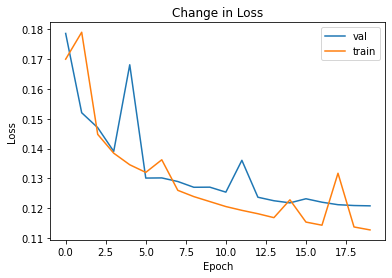

In [28]:
plt_data = {
    "val": test_losses,
    "train": train_losses,
}
plot_graph(plt_data, "Loss")